# Plot Your CitiBike Rides! 
Developer: @mattwfranchi

This notebook contains code to map out your CitiBike rides in the New York City metro area, upon exporting a HTML file of your [rides page](https://account.citibikenyc.com/ride-history).

The exact route is estimated via a shortest path algorithm locked to the bike network, as reported by OpenStreetMap. I provide my 2023 rides as an example. The contextily base map can either be commented out, or provide an free API key for [Stadia Maps](https://client.stadiamaps.com/signup/). Pip-install the packages in the below cell. 

I provide the station locations CSV as well, but if you want to recompute, simply download a month of ride data from [link](https://s3.amazonaws.com/tripdata/index.html). 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import random
import matplotlib.colors as mcolors
import calendar

import geopandas as gpd
from bs4 import BeautifulSoup

from shapely.geometry import Point, LineString

# plot
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox

In [2]:
# Function to extract bike ride details from a 'div' element
def extract_bike_ride_details(div_element):
    ride_details = {}

    # Extracting the primary details like Date, Price, Start Time, and Duration
    primary_div = div_element.find("div", class_="Components__Primary-sc-1ff1hfy-3 fiNHEp")
    ride_details['Date'] = primary_div.find("div", class_="sc-cx1xxi-0 kDzQzX").get_text(strip=True)
    detail_divs = primary_div.find_all("div", class_="Components__Detail-sc-1ff1hfy-9 dmtsts")
    ride_details['Price'] = detail_divs[0].get_text(strip=True).split(':')[-1].strip()
    ride_details['Start Time'] = detail_divs[1].get_text(strip=True).strip('Start Time:').strip()
    ride_details['Duration'] = detail_divs[2].get_text(strip=True).split(':')[-1].strip()

    # Extracting the secondary details like Start and End Locations
    secondary_div = div_element.find_next_sibling("div", {"data-testid": "DATA_TESTID_RIDE_DETAILS_CONTAINER"})
    start_end_divs = secondary_div.find_all("div", class_="sc-cx1xxi-0 lbVIIX")
    ride_details['Start Location'] = start_end_divs[0].get_text(strip=True).split("Started at")[0].strip()
    ride_details['End Location'] = start_end_divs[1].get_text(strip=True).split("Ended at")[0].strip()

    # Extracting the type of bike by searching all span elements for "Ebike ride"
    all_spans = secondary_div.find_all("span")
    ride_details['Bike Type'] = "Ebike" if any("Ebike ride" in span.get_text() for span in all_spans) else "Normal Bike"

    return ride_details

# Function to process the HTML file and extract bike ride data
def process_bike_rides(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    bike_ride_cards = soup.find_all("div", {"data-testid": "DATA_TESTID_RIDE_OVERVIEW_CARD"})

    bike_ride_data = [extract_bike_ride_details(card) for card in bike_ride_cards]
    return pd.DataFrame(bike_ride_data)



In [3]:
# File path to the HTML file
file_path = 'data/citibike_ride_history.html'  # Replace with the path to your HTML file

# Process the file and get the DataFrame
df_bike_rides = process_bike_rides(file_path)

In [4]:
df_bike_rides

,Date,Price,Start Time,Duration,Start Location,End Location,Bike Type
0,"December 16, 2023",$4.81,3:28 AM,26 min,4 Ave & E 12 St,Roosevelt Island Tramway,Ebike
1,"December 13, 2023",$2.22,1:54 AM,12 min,49 Ave & 21 St,Roosevelt Island Tramway,Ebike
2,"December 12, 2023",$2.22,6:06 PM,12 min,45 Ave & 21 St,Roosevelt Island Tramway,Ebike
3,"December 10, 2023",$0.00,6:55 PM,4 min,46 Ave & 5 St,Center Blvd & 51 Ave,Normal Bike
4,"December 10, 2023",$2.04,3:03 AM,11 min,44 Dr & Jackson Ave,Roosevelt Island Tramway,Ebike
...,...,...,...,...,...,...,...
88,"August 23, 2023",$1.30,7:54 PM,7 min,36 Ave & 10 St,Roosevelt Island Tramway,Ebike
89,"August 23, 2023",$0.00,7:30 PM,23 min,35 St & Broadway,36 Ave & 10 St,Normal Bike
90,"August 23, 2023",$0.00,6:04 PM,15 min,36 Ave & 10 St,35 St & Broadway,Normal Bike
91,"August 23, 2023",$1.67,5:07 PM,9 min,Southpoint Park,36 Ave & 10 St,Ebike


In [5]:
df_bike_rides.to_csv('data/citibike_ride_history.csv', index=False)

In [6]:
# ALT: GENERATE STATION ADDRESSES FROM CITI BIKE DATA
# read in citi bike system data 
#df_citi = pd.read_csv('data/202311-citibike-tripdata.csv', low_memory=False)

# group by start_station name to find all unique stations 
#df_citi_grouped = df_citi.groupby('start_station_name').agg('first')

#df_citi_grouped = df_citi_grouped.reset_index()
#df_citi_grouped = df_citi_grouped[['start_station_name', 'start_lat', 'start_lng']]

#df_citi_station_addresses = df_citi_grouped 
#df_citi_station_addresses.columns = ['Station Name', 'Latitude', 'Longitude']

# USING PREGENERATED STATION ADDRESSES
df_citi_station_addresses = pd.read_csv('data/citibike_station_addresses.csv')

# if regenerating manually, set CRS here to EPSG:4326, and then project to EPSG:2263
df_citi_station_addresses = gpd.GeoDataFrame(df_citi_station_addresses, geometry=gpd.points_from_xy(df_citi_station_addresses.Longitude, df_citi_station_addresses.Latitude), crs='EPSG:2263')

# update Latitude and Longitude to match the projected geometry
df_citi_station_addresses['Latitude'] = df_citi_station_addresses.geometry.y
df_citi_station_addresses['Longitude'] = df_citi_station_addresses.geometry.x

In [7]:
df_citi_station_addresses

,Station Name,Latitude,Longitude,geometry
0,1 Ave & E 110 St,227939.737227,1.001363e+06,POINT (1001363.231 227939.737)
1,1 Ave & E 16 St,206023.882314,9.893094e+05,POINT (989309.360 206023.882)
2,1 Ave & E 18 St,206624.955954,9.896419e+05,POINT (989641.924 206624.956)
3,1 Ave & E 30 St,209450.223705,9.910897e+05,POINT (991089.694 209450.224)
4,1 Ave & E 39 St,211481.435991,9.922494e+05,POINT (992249.373 211481.436)
...,...,...,...,...
2079,Wyckoff Ave & Stanhope St,195607.812124,1.007048e+06,POINT (1007048.187 195607.812)
2080,Wyckoff St & 3 Ave,188051.519400,9.890613e+05,POINT (989061.334 188051.519)
2081,Wythe Ave & Metropolitan Ave,200524.563747,9.945173e+05,POINT (994517.284 200524.564)
2082,Wythe Ave & N 13 St,202604.005990,9.961669e+05,POINT (996166.908 202604.006)


In [8]:
# now, merge my rides with the citi bike station data
df_bike_rides = df_bike_rides.merge(df_citi_station_addresses, how='left', left_on='Start Location', right_on='Station Name')
df_bike_rides = df_bike_rides.merge(df_citi_station_addresses, how='left', left_on='End Location', right_on='Station Name', suffixes=('_start', '_end'))

In [9]:
df_bike_rides

,Date,Price,Start Time,Duration,Start Location,End Location,Bike Type,Station Name_start,Latitude_start,Longitude_start,geometry_start,Station Name_end,Latitude_end,Longitude_end,geometry_end
0,"December 16, 2023",$4.81,3:28 AM,26 min,4 Ave & E 12 St,Roosevelt Island Tramway,Ebike,4 Ave & E 12 St,206199.988145,9.869909e+05,POINT (986990.904 206199.988),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215)
1,"December 13, 2023",$2.22,1:54 AM,12 min,49 Ave & 21 St,Roosevelt Island Tramway,Ebike,49 Ave & 21 St,209823.829244,9.983927e+05,POINT (998392.707 209823.829),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215)
2,"December 12, 2023",$2.22,6:06 PM,12 min,45 Ave & 21 St,Roosevelt Island Tramway,Ebike,45 Ave & 21 St,211568.520867,9.987212e+05,POINT (998721.205 211568.521),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215)
3,"December 10, 2023",$0.00,6:55 PM,4 min,46 Ave & 5 St,Center Blvd & 51 Ave,Normal Bike,46 Ave & 5 St,211545.339225,9.968545e+05,POINT (996854.495 211545.339),Center Blvd & 51 Ave,210082.440557,9.954471e+05,POINT (995447.100 210082.441)
4,"December 10, 2023",$2.04,3:03 AM,11 min,44 Dr & Jackson Ave,Roosevelt Island Tramway,Ebike,44 Dr & Jackson Ave,211500.654971,9.999708e+05,POINT (999970.755 211500.655),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"August 23, 2023",$1.30,7:54 PM,7 min,36 Ave & 10 St,Roosevelt Island Tramway,Ebike,36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215)
89,"August 23, 2023",$0.00,7:30 PM,23 min,35 St & Broadway,36 Ave & 10 St,Normal Bike,35 St & Broadway,216281.048071,1.005755e+06,POINT (1005755.045 216281.048),36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693)
90,"August 23, 2023",$0.00,6:04 PM,15 min,36 Ave & 10 St,35 St & Broadway,Normal Bike,36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),35 St & Broadway,216281.048071,1.005755e+06,POINT (1005755.045 216281.048)
91,"August 23, 2023",$1.67,5:07 PM,9 min,Southpoint Park,36 Ave & 10 St,Ebike,Southpoint Park,213849.768503,9.956525e+05,POINT (995652.508 213849.769),36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693)


In [10]:
# any na values? 
df_bike_rides.isna().sum()

Date                  0
Price                 0
Start Time            0
Duration              0
Start Location        0
End Location          0
Bike Type             0
Station Name_start    3
Latitude_start        3
Longitude_start       3
geometry_start        3
Station Name_end      3
Latitude_end          3
Longitude_end         3
geometry_end          3
dtype: int64

In [11]:
# check na rows 
for row in ['Station Name_start', 'Station Name_end']:
    print(df_bike_rides[df_bike_rides[row].isna()].to_string()+'\n')

                  Date   Price Start Time     Duration     Start Location          End Location    Bike Type Station Name_start  Latitude_start  Longitude_start geometry_start      Station Name_end   Latitude_end  Longitude_end                   geometry_end
57  September 21, 2023   $0.00    2:40 AM       10 min  E 9 St & Avenue C       E 11 St & 1 Ave  Normal Bike                NaN             NaN              NaN           None       E 11 St & 1 Ave  205067.655684  988610.398208  POINT (988610.398 205067.656)
79     August 27, 2023  $11.48    1:55 AM  1 hr, 2 min  E 2 St & Avenue B       Southpoint Park        Ebike                NaN             NaN              NaN           None       Southpoint Park  213849.768503  995652.507953  POINT (995652.508 213849.769)
80     August 27, 2023   $8.70    1:55 AM       47 min  E 2 St & Avenue B  Broadway & Moylan Pl        Ebike                NaN             NaN              NaN           None  Broadway & Moylan Pl  235975.215153  995587.07

In [12]:
# upon inspection, the station names are slightly different. Not sure if this happens at other stations I hadn't been to this year,
# so update this mapper if you have other stations from the previous cell with different names
station_name_map = { 
    "E 9 St & Ave C": "E 9 St & Avenue C",
    "E 2 St & Ave B": "E 2 St & Avenue B",
}


# run the map through df_bike_rides and replace the station names, if necessary
for row in ['Station Name_start', 'Station Name_end']:
    df_bike_rides[row] = df_bike_rides[row].replace(station_name_map)


In [13]:
# check na rows 
for row in ['Station Name_start', 'Station Name_end']:
    print(df_bike_rides[df_bike_rides[row].isna()].to_string()+'\n')

# we're good! no NA rows. 

                  Date   Price Start Time     Duration     Start Location          End Location    Bike Type Station Name_start  Latitude_start  Longitude_start geometry_start      Station Name_end   Latitude_end  Longitude_end                   geometry_end
57  September 21, 2023   $0.00    2:40 AM       10 min  E 9 St & Avenue C       E 11 St & 1 Ave  Normal Bike                NaN             NaN              NaN           None       E 11 St & 1 Ave  205067.655684  988610.398208  POINT (988610.398 205067.656)
79     August 27, 2023  $11.48    1:55 AM  1 hr, 2 min  E 2 St & Avenue B       Southpoint Park        Ebike                NaN             NaN              NaN           None       Southpoint Park  213849.768503  995652.507953  POINT (995652.508 213849.769)
80     August 27, 2023   $8.70    1:55 AM       47 min  E 2 St & Avenue B  Broadway & Moylan Pl        Ebike                NaN             NaN              NaN           None  Broadway & Moylan Pl  235975.215153  995587.07

In [14]:
# drop na rows
df_bike_rides = df_bike_rides.dropna()

In [15]:


# nyc roads graph from place 
nyc = ox.graph_from_place('New York City, New York, USA', network_type='bike')
nyc = ox.distance.add_edge_lengths(nyc)

# to gdf 
nyc_gdf = ox.graph_to_gdfs(nyc, nodes=False, edges=True)
# project to 2263 
nyc_gdf = nyc_gdf.set_crs(epsg=4326)
nyc_gdf = nyc_gdf.to_crs(epsg=2263)

In [16]:
# set graph crs 
nyc = ox.project_graph(nyc, to_crs=2263)

In [17]:
# compute shortest path with osmnx between each starting and ending point, and then make gdf with linestring
df_bike_rides['start_point'] = df_bike_rides.apply(lambda row: Point(row['Longitude_start'], row['Latitude_start']), axis=1)
df_bike_rides['end_point'] = df_bike_rides.apply(lambda row: Point(row['Longitude_end'], row['Latitude_end']), axis=1)

In [18]:
df_bike_rides

,Date,Price,Start Time,Duration,Start Location,End Location,Bike Type,Station Name_start,Latitude_start,Longitude_start,geometry_start,Station Name_end,Latitude_end,Longitude_end,geometry_end,start_point,end_point
0,"December 16, 2023",$4.81,3:28 AM,26 min,4 Ave & E 12 St,Roosevelt Island Tramway,Ebike,4 Ave & E 12 St,206199.988145,9.869909e+05,POINT (986990.904 206199.988),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215),POINT (986990.9039654374 206199.988145324),POINT (997110.5831078328 215173.2145505548)
1,"December 13, 2023",$2.22,1:54 AM,12 min,49 Ave & 21 St,Roosevelt Island Tramway,Ebike,49 Ave & 21 St,209823.829244,9.983927e+05,POINT (998392.707 209823.829),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215),POINT (998392.7073301204 209823.82924439415),POINT (997110.5831078328 215173.2145505548)
2,"December 12, 2023",$2.22,6:06 PM,12 min,45 Ave & 21 St,Roosevelt Island Tramway,Ebike,45 Ave & 21 St,211568.520867,9.987212e+05,POINT (998721.205 211568.521),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215),POINT (998721.20481705 211568.5208667933),POINT (997110.5831078328 215173.2145505548)
3,"December 10, 2023",$0.00,6:55 PM,4 min,46 Ave & 5 St,Center Blvd & 51 Ave,Normal Bike,46 Ave & 5 St,211545.339225,9.968545e+05,POINT (996854.495 211545.339),Center Blvd & 51 Ave,210082.440557,9.954471e+05,POINT (995447.100 210082.441),POINT (996854.494964951 211545.33922499855),POINT (995447.099902163 210082.44055688815)
4,"December 10, 2023",$2.04,3:03 AM,11 min,44 Dr & Jackson Ave,Roosevelt Island Tramway,Ebike,44 Dr & Jackson Ave,211500.654971,9.999708e+05,POINT (999970.755 211500.655),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215),POINT (999970.7546327892 211500.6549706817),POINT (997110.5831078328 215173.2145505548)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"August 23, 2023",$1.30,7:54 PM,7 min,36 Ave & 10 St,Roosevelt Island Tramway,Ebike,36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),Roosevelt Island Tramway,215173.214551,9.971106e+05,POINT (997110.583 215173.215),POINT (1000559.392218714 216694.69302944464),POINT (997110.5831078328 215173.2145505548)
89,"August 23, 2023",$0.00,7:30 PM,23 min,35 St & Broadway,36 Ave & 10 St,Normal Bike,35 St & Broadway,216281.048071,1.005755e+06,POINT (1005755.045 216281.048),36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),POINT (1005755.0449738645 216281.0480711439),POINT (1000559.392218714 216694.69302944464)
90,"August 23, 2023",$0.00,6:04 PM,15 min,36 Ave & 10 St,35 St & Broadway,Normal Bike,36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),35 St & Broadway,216281.048071,1.005755e+06,POINT (1005755.045 216281.048),POINT (1000559.392218714 216694.69302944464),POINT (1005755.0449738645 216281.0480711439)
91,"August 23, 2023",$1.67,5:07 PM,9 min,Southpoint Park,36 Ave & 10 St,Ebike,Southpoint Park,213849.768503,9.956525e+05,POINT (995652.508 213849.769),36 Ave & 10 St,216694.693029,1.000559e+06,POINT (1000559.392 216694.693),POINT (995652.5079534876 213849.7685027907),POINT (1000559.392218714 216694.69302944464)


In [19]:
# get nearest node to each start and end point
df_bike_rides['start_node'] = df_bike_rides.apply(lambda row: ox.distance.nearest_nodes(nyc, row['start_point'].x, row['start_point'].y, return_dist=False), axis=1)
df_bike_rides['end_node'] = df_bike_rides.apply(lambda row: ox.distance.nearest_nodes(nyc, row['end_point'].x, row['end_point'].y, return_dist=False), axis=1)

In [20]:
# shortest path with osmnx 
df_bike_rides['shortest_path'] = df_bike_rides.apply(lambda row: ox.shortest_path(nyc, row['start_node'], row['end_node']), axis=1)

In [21]:

# then, for each shortest path, get the edge lengths and sum them
# make edges out of each pair of nodes in shortest path
def get_edge_lengths(shortest_path):
    edge_lengths = []
    for i in range(len(shortest_path)-1):
        edge_lengths.append(nyc[shortest_path[i]][shortest_path[i+1]][0]['length'])
    return edge_lengths

df_bike_rides['edge_lengths'] = df_bike_rides['shortest_path'].apply(get_edge_lengths)

# sum edge lengths
df_bike_rides['distance'] = df_bike_rides['edge_lengths'].apply(lambda x: sum(x))


In [22]:
# convert distance from meters to miles 
df_bike_rides['distance'] = df_bike_rides['distance'] * 0.000621371


# describe distance
df_bike_rides['distance'].describe()


count    87.000000
mean      2.877928
std       2.371434
min       0.000000
25%       1.000427
50%       2.098547
75%       4.602647
max      10.226281
Name: distance, dtype: float64

In [23]:
# how many total miles biked (approximate)? 
df_bike_rides['distance'].sum()

# pretty close! citi bike app reports 255 miles biked 

250.37970150434506

In [24]:
# make geopandas dataframe with line geometry from shortest path
df_bike_rides['geometry'] = df_bike_rides.apply(lambda x: LineString([(x['Longitude_start'], x['Latitude_start']), (x['Longitude_end'], x['Latitude_end'])]), axis=1)
#df_bike_rides['geometry'] = df_bike_rides.apply(lambda x: ox.make_folium_polyline(nyc, x['shortest_path'], edge_color='red', edge_width=2, edge_opacity=1), axis=1)
df_bike_rides_gdf = gpd.GeoDataFrame(df_bike_rides, geometry='geometry')





In [25]:
# generate route colors by month 


# turn date column into datetime
df_bike_rides_gdf['Date'] = pd.to_datetime(df_bike_rides_gdf['Date'])

# get month from date
df_bike_rides_gdf['Month'] = df_bike_rides_gdf['Date'].apply(lambda x: calendar.month_name[x.month])

# get unique months
months = df_bike_rides_gdf['Month'].unique()

# generate colors for each month

colors = []
# split up a color map into color for each month 
cmap = plt.cm.get_cmap('plasma')
for i in range(len(months)):
    colors.append(cmap(i/len(months)))




# make dictionary of month to color
month_to_color = {}
for i in range(len(months)):
    month_to_color[months[i]] = colors[i]

# map month to color
df_bike_rides_gdf['color'] = df_bike_rides_gdf.apply(lambda row: month_to_color[row['Month']], axis=1)





/var/folders/rz/q4x269y17917jm35bvx33y6m0000gn/T/ipykernel_7196/2337082980.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma')


In [26]:
# generate dynamic route widths based on number of rides on that route
# group rides by starting and ending station
df_bike_rides_gdf_grouped = df_bike_rides_gdf.groupby(['Start Location', 'End Location']).agg('count').reset_index()

# merge with df bike rides gdf to make a dynamic width column
df_bike_rides_gdf = df_bike_rides_gdf.merge(df_bike_rides_gdf_grouped[['Start Location', 'End Location', 'Date']], how='left', on=['Start Location', 'End Location'])
df_bike_rides_gdf = df_bike_rides_gdf.rename(columns={'Date_y': 'num_rides', 'Date_x': 'Date'})

# describe num rides
df_bike_rides_gdf['num_rides'].describe()

# add offset to num rides for visual aesthetics
df_bike_rides_gdf['num_rides'] = df_bike_rides_gdf['num_rides'] + 2


/Users/mattfranchi/anaconda3/envs/geospatial/lib/python3.12/site-packages/osmnx/plot.py:309: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


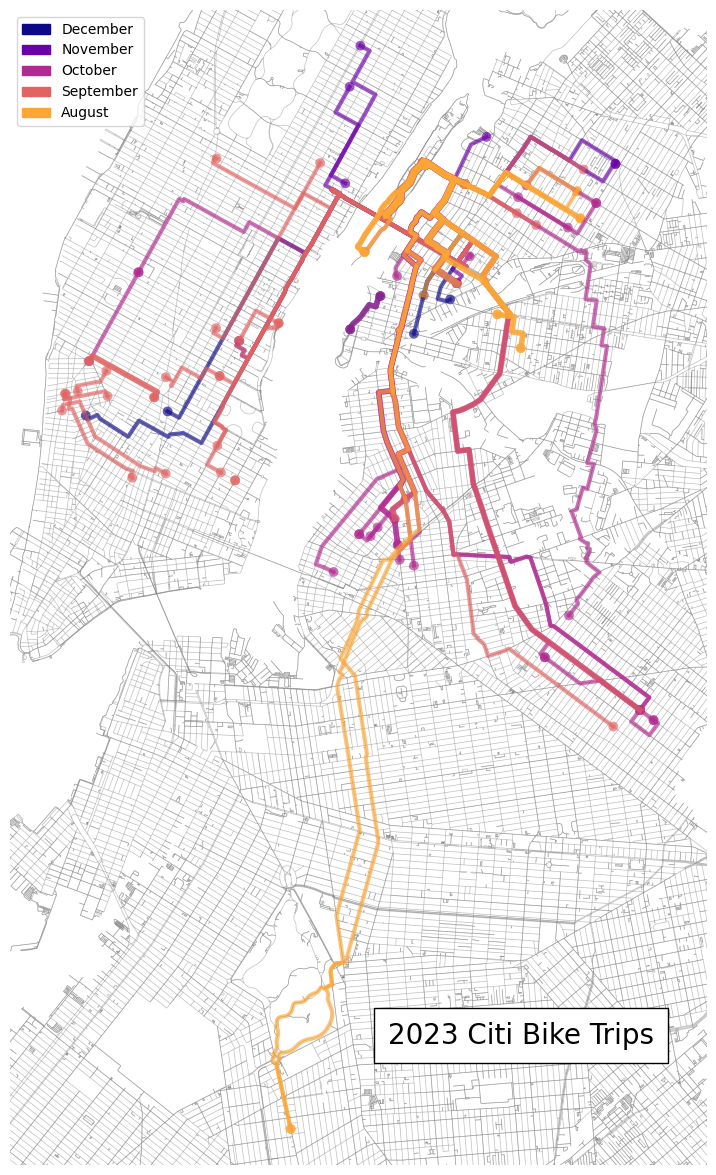

In [27]:
fig, ax = plt.subplots(figsize=(15,15))

# zoom in to range of df_bike_rides['shortest_path'], but use (north, south, east, west) instead of (west, south, east, north)
bbox = df_bike_rides_gdf.total_bounds

north, west, south, east = bbox[3], bbox[0], bbox[1], bbox[2]

# pad bbox by PAD
PAD = 10000
north += PAD/6
south -= PAD/6
east += PAD/4
west -= PAD/4


bbox_corrected = (north, south, east, west)

# add text box on bottom right of plot 
text = '2023 Citi Bike Trips'
ax.text(0.925, 0.1, text, transform=ax.transAxes, fontsize=20, color='black', ha='right', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='black', pad=10))


# add legend
import matplotlib.patches as mpatches
patches = []
for month in months:
    patches.append(mpatches.Patch(color=month_to_color[month], label=month))
ax.legend(handles=patches, loc='upper left')

ox.plot.plot_graph(nyc, ax=ax, bbox=bbox_corrected, node_size=0, edge_linewidth=0.5, edge_color='grey', edge_alpha=0.5, show=False, save=False, close=False, filepath="images/citibike_routes.png")

# plot shortest routes with ox
ox.plot.plot_graph_routes(nyc, df_bike_rides['shortest_path'], route_colors=df_bike_rides_gdf.color.values, route_linewidths=df_bike_rides_gdf.num_rides.values, route_alpha=0.65, orig_dest_size=50, ax=ax, show=False, save=False, close=False, filepath="images/citibike_routes.png")



# add basemap (this will only work properly if you add an API key, wont put mine here for obvious reasons)
#YOUR_STADIA_API_KEY = ''
#ctx.add_basemap(ax, crs=nyc_gdf.crs.to_string(), source='https://tiles.stadiamaps.com/data/satellite/{z}/{x}/{y}.jpg?api_key='+YOUR_STADIA_API_KEY, alpha=0.9)

plt.show()

# save figure
fig.savefig('images/citibike_routes.png', dpi=300, bbox_inches='tight', pad_inches=0.0)



